### Analyze Sensitivity Results

In [14]:
import os
import pandas as pd
res_dir = 'nb_hydr_static_v5_sssim_cali_exp_4_1'
cali_dir = 'cali_exp_4'
if not os.path.isdir(cali_dir):
    os.mkdir(cali_dir)
calibration_data_org = pd.read_csv('2020P2_calibration_data_30m.csv')
contents = os.listdir(res_dir)

In [15]:
import os
import pandas as pd
results = []

result_name = 'chw_sup_m.m_flow'
outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
result_idx = outputs.index(result_name)
for content in contents:
    result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
    result_pd = pd.read_csv(result_file_path, header = None)
    results.append(result_pd.values[:, result_idx])
print(len(results))

300


In [21]:
import numpy as np
# get calibration true data
# since each run may only randomly select a subset of calibration data, so each run has different calibration true data
calibration_datas = []

for content in contents:
    result_file_path = res_dir + os.sep + content + os.sep + 'random_indices.csv'
    print(result_file_path)
    indices_array = np.genfromtxt(result_file_path, delimiter=',')
    calibration_data_i = calibration_data_org.iloc[indices_array, :]
    calibration_datas.append(calibration_data_i)
print(len(calibration_datas))

nb_hydr_static_v5_sssim_cali_exp_4_1/run_263/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_59/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_98/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_96/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_109/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_107/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_27/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_268/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_200/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_184/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_153/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_45/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_42/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_199/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_43/random_indices.csv
nb_hydr_static_v5_sssim_cali_exp_4_1/run_116/ra

In [22]:
# remove results with none
import numpy as np
val_idx = []
for i in range(len(results)):
    result_i = results[i]
    if np.isnan(result_i).sum() == 0:
        val_idx.append(i)
results_clean = [results[j] for j in val_idx]


val_idx_col = []
for i in range(np.array(results).shape[1]):
    result_i = np.array(results)[:, i]
    if np.isnan(result_i).sum() == 0:
        val_idx_col.append(i)
len(val_idx)

300

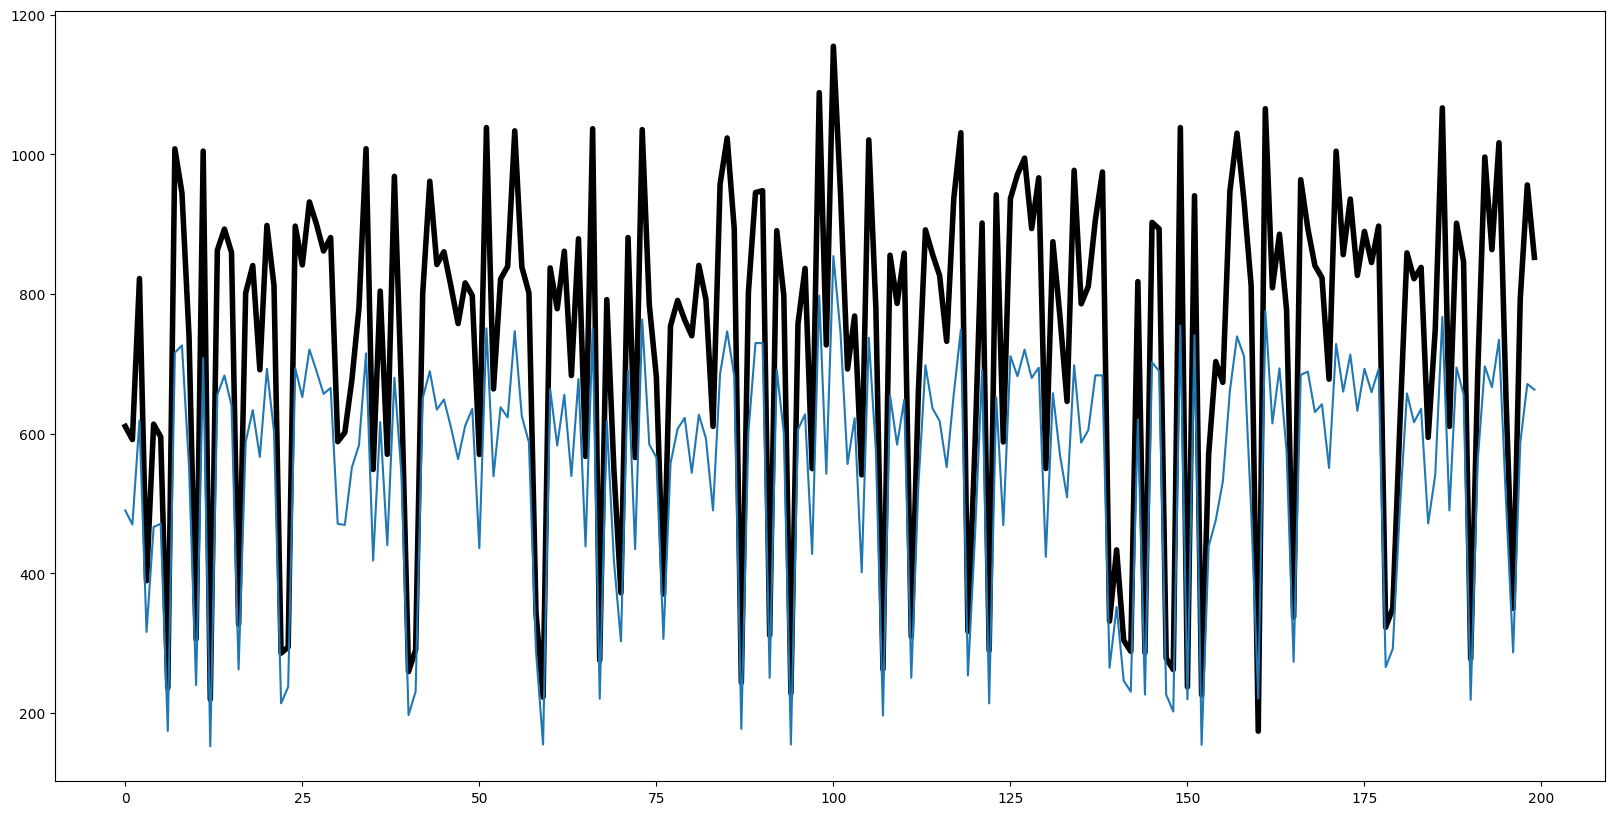

In [23]:
import matplotlib.pyplot as plt
import numpy as np
i = 31
fig, axs = plt.subplots(1, figsize = (20, 10))
axs.plot(calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values,
         color = 'k', linewidth = 4, label = 'True')
mapes = []
cvrmses = []
result_this = results_clean[i]
axs.plot(result_this, label = 'run_{}'.format(i))
mape_i = 100*(abs(calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values 
             - np.array(result_this))/\
             calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values).mean()
mapes.append(mape_i)
cvrmse_i = (((calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values 
             - np.array(result_this))**2).sum()/len(result_this))**0.5/\
            calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values.mean()
cvrmses.append(cvrmse_i)
    

In [24]:
def get_t(mo_path):
    chr_pipe_len = None
    chr_v_nom = None
    with open(mo_path) as file:
        lines = file.readlines()
        for line in lines:
            if 'parameter Real chiller_pipe_len=' in line:
                chr_pipe_len = float(line
                                     .split('parameter Real chiller_pipe_len=')[-1]
                                     .split('"m";')[0]
                                     .strip())
            if 'parameter Real chiller_v_nominal=' in line:
                chr_v_nom = float(line
                                     .split('parameter Real chiller_v_nominal=')[-1]
                                     .split('"m/s";')[0]
                                     .strip())
            if chr_pipe_len is not None and chr_v_nom is not None:
                break
    return chr_pipe_len, chr_v_nom
            

In [25]:
# prepare data files for calibration
mo_file_name = 'nb_hydr_static_v6.mo'
result_name = 'chw_sup_m.m_flow'
calibration_x_names = ['NB2_S_1_NYZ_sys_x_PcwOut_x','NB2_S_1_NYZ_sys_x_PcwIn_x',
             'NB2_S_1_NYZ_cwp_9_HzSPR_x','NB2_S_1_NYZ_cwp_10_HzSPR_x',
             'NB2_S_1_NYZ_cwp_11_HzSPR_x','NB2_S_1_NYZ_cwp_12_HzSPR_x']
outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
result_idx = outputs.index(result_name)

for i in range(len(contents)):
    content = contents[i]
    # get the corresponding calibration data
    calibration_x = calibration_datas[i][calibration_x_names].values

    result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
    result_pd = pd.read_csv(result_file_path, header = None)
    sim_y = result_pd.values[:, result_idx].reshape(-1, 1)
    cali_sim_data = np.concatenate((sim_y, calibration_x), axis = 1)
    mo_file_path = res_dir + os.sep + content\
                + os.sep + 'compilation'\
                + os.sep + mo_file_name
    chr_pipe_len, chr_v_nom = get_t(mo_file_path)
    sim_t = np.ones((sim_y.shape[0], 2)) * (chr_pipe_len, chr_v_nom)
    cali_sim_data = np.concatenate((cali_sim_data, sim_t), axis = 1)
    cali_sim_data = pd.DataFrame(cali_sim_data)
    column_names = ['m_flow_pred']
    column_names.extend(calibration_x_names)
    column_names.extend(['chiller_pipe_len', 'chiller_v_nominal'])
    cali_sim_data.columns = column_names
    cali_sim_data.to_csv(res_dir + os.sep + content + os.sep + 'cali_sim_data.csv', index=False)

In [26]:
# get all parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []

for content in contents:

    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    data_i = pd.read_csv(data_file_path)
    parameters.append(data_i.values[0, -2: ])            
parameters = np.array(parameters)
print(parameters[val_idx])

[[ 31.54165541   1.17963034]
 [147.87599845   1.74571634]
 [ 35.58065033   0.9626765 ]
 [122.44079475   1.57126001]
 [112.28815939   1.02854504]
 [ 58.25715944   0.64332566]
 [ 25.50171329   1.1130342 ]
 [ 28.47824013   1.36265462]
 [ 61.08850933   0.90508252]
 [ 69.42768603   1.08379257]
 [ 35.14257912   1.84873359]
 [ 77.87482018   0.88921909]
 [ 74.73013918   1.69207618]
 [ 49.48822847   1.19012889]
 [109.50126857   1.28629564]
 [ 98.90250048   0.65343512]
 [ 30.86284075   1.43517371]
 [ 96.17127834   1.80519636]
 [100.45817555   1.89036315]
 [100.58201083   1.08157241]
 [109.42237615   1.83168008]
 [122.59125545   0.95707293]
 [ 51.31547057   1.64613711]
 [104.91920834   1.03615139]
 [ 30.66765829   0.84161884]
 [145.21656754   1.33209922]
 [ 47.62078272   1.07194644]
 [ 64.80331609   0.88617372]
 [134.99694704   1.52159673]
 [ 72.19152888   0.87621921]
 [ 66.7564425    1.00214361]
 [146.67248454   1.17196364]
 [116.78715953   1.78193827]
 [115.08516745   1.20829184]
 [117.18050714

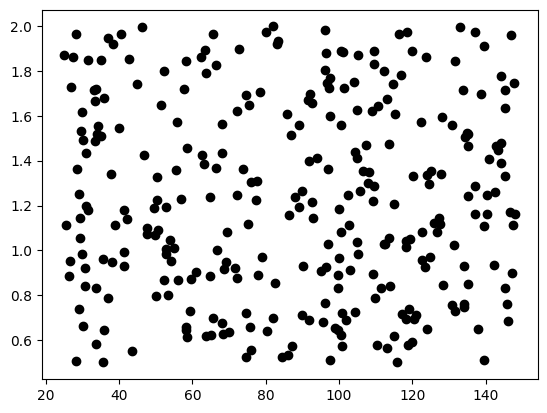

In [27]:
plt.scatter(parameters[:, 0], parameters[:, 1], color ='k')

In [28]:
# get a closer range for the parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []
narrowed_run_dirs = []
mape_thres = 100

for i in range(len(contents)):
    content = contents[i]
    y_true = calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values
    
    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    data_i = pd.read_csv(data_file_path)
    y_pred_i = data_i['m_flow_pred'].values
    mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
    if mape_i <= mape_thres:
        parameters.append(data_i.values[0, -2: ])
        narrowed_run_dirs.append(res_dir + os.sep + content)
            
parameters = np.array(parameters)
print(len(narrowed_run_dirs))

/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(ab

288


/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
/tmp/ipykernel_3393455/1637504200.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()


In [29]:
# collect all cali_sim_data
cali_sim_data_all = None

for i in range(len(contents)):
    content = contents[i]
    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    if (res_dir + os.sep + content) in narrowed_run_dirs:
        data_i = pd.read_csv(data_file_path)
        if cali_sim_data_all is None:
            cali_sim_data_all = data_i
        else:
            cali_sim_data_all = pd.concat([cali_sim_data_all, data_i],
                                  ignore_index = True)

In [30]:
cali_sim_data_all.shape

(57600, 9)

In [31]:
cali_sim_data_all.to_csv('{}/cali_sim_data_all.csv'.format(cali_dir),
                        index=False)

In [47]:
# Down sample
from BayesianCalibration.DownSampler import DownSampler
import pandas as pd
field_data_columns = ['NB2_S_x_NYZ_x_x_Fcw_x', 'NB2_S_1_NYZ_sys_x_PcwOut_x', 
                      'NB2_S_1_NYZ_sys_x_PcwIn_x', 'NB2_S_1_NYZ_cwp_9_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_10_HzSPR_x', 'NB2_S_1_NYZ_cwp_11_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_12_HzSPR_x']

cali_sim_data_path = './{}/cali_sim_data_all.csv'.format(cali_dir)
field_df = calibration_data_org[field_data_columns]

bins = 50
quality_thres_sim = 0.7
quality_thres_field = 0.7
dirichlet_prior = 0.5
sim_df = pd.read_csv(cali_sim_data_path)
d_sim = sim_df.values
d_field = field_df.values

ds_d_sim = DownSampler(d_sim, bins = bins, dirichlet_prior = dirichlet_prior)
(d_sim_down, d_sim_sp_hist) = ds_d_sim.sample(stSampleSize = 50, 
                                              increRatio = 1.05, 
                                              qualityThres = quality_thres_sim)
d_sim_down_df = pd.DataFrame(d_sim_down)
d_sim_down_df.columns = [list(sim_df.columns)]
d_sim_down_df.to_csv('./{}/cali_sim_data_down.csv'.format(cali_dir), index = False)

ds_d_field = DownSampler(d_field, bins = bins, dirichlet_prior = dirichlet_prior)
(d_field_down, d_field_sp_hist) = ds_d_field.sample(stSampleSize = 50, 
                                              increRatio = 1.05, 
                                              qualityThres = quality_thres_field)
d_field_down_df = pd.DataFrame(d_field_down)
d_field_down_df.columns = [field_data_columns]
d_field_down_df.to_csv('./{}/cali_field_data_down.csv'.format(cali_dir), index = False)

[0.00306291 0.00828633 0.01500217 0.02065944 0.02341866 0.02461605
 0.02487636 0.02428633 0.02378308 0.02281128 0.02031236 0.01947939
 0.01935792 0.02206508 0.0236269  0.02602169 0.02805206 0.02918004
 0.03263341 0.03455965 0.03339696 0.0347679  0.03624295 0.03384816
 0.03265076 0.03353579 0.03233839 0.02992625 0.03001302 0.02888503
 0.02973536 0.02723644 0.02487636 0.02345336 0.02260304 0.02111063
 0.01866377 0.01793492 0.01377007 0.0095705  0.00757484 0.00478091
 0.00292408 0.00193492 0.00113666 0.00045987 0.00018221 0.00013015
 0.0001128  0.0001128 ]
52
54
56
58
60
63
66
69
72
75
78
81
85
89
93
97
101
106
111
116
121
127
133
139
145
152
159
166
174
182
191
[0.00063105 0.00021035 0.00105175 0.00105175 0.00021035 0.00147244
 0.00231384 0.00273454 0.00399663 0.01493479 0.03050063 0.04774926
 0.04522507 0.02250736 0.02208666 0.00652082 0.00357594 0.00021035
 0.00147244 0.00105175 0.00063105 0.00231384 0.00988641 0.02629365
 0.03344552 0.03218342 0.0380732  0.02376946 0.02545225 0.017038